# Question 6

---


## Step 0: Setup & Imports


In [2]:
# zaroori cheezen import kar lete hain
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# repeatability ke liye seed set
np.random.seed(42)

## Step 1: Original moons dataset


In [3]:
# do half-moons wala toy dataset
X, y = make_moons(
    n_samples=1000, noise=0.15, random_state=42
)  # shape (1000,2), (1000,)
X = X.astype(np.float32)
y = y.astype(np.int64)

## Step 2: Augmentation — Gaussian noise + horizontal flip (some points)


In [4]:
# gaussian noise add kerni hai
noise = np.random.normal(loc=0.0, scale=0.10, size=X.shape).astype(
    np.float32
)  # halki si
X_noisy = X + noise

# kuch points ko flip kar dete hain horizontally: x -> -x
flip_mask = np.random.rand(len(X)) < 0.5  # aadhe roughly flip ho jaayen ge
X_flip = X_noisy.copy()
X_flip[flip_mask, 0] = -X_flip[flip_mask, 0]

# augmented set bana lete hain (concat original + augmented)
X_aug = np.vstack([X, X_flip]).astype(np.float32)
y_aug = np.hstack([y, y]).astype(np.int64)

## Step 3: Plot original vs augmented


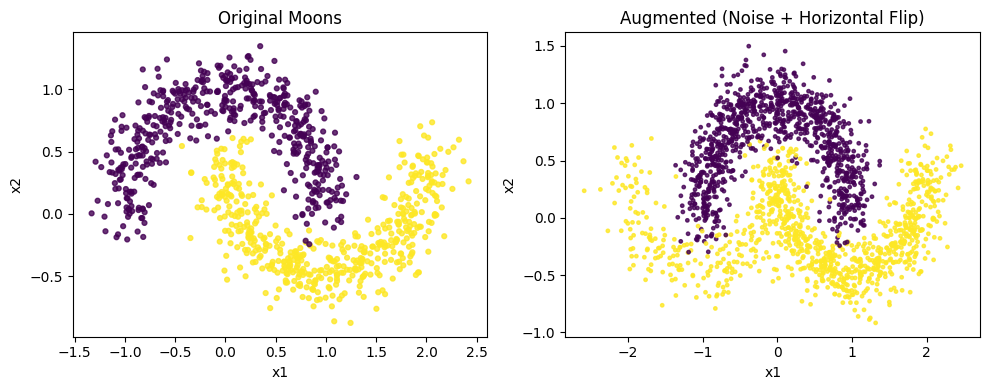

In [5]:
# side-by-side plots taake farq nazar aaye
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=12, alpha=0.8)
plt.title("Original Moons")
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1, 2, 2)
plt.scatter(X_aug[:, 0], X_aug[:, 1], c=y_aug, s=6, alpha=0.8)
plt.title("Augmented (Noise + Horizontal Flip)")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()


**Q6 Explanation (Overfitting ko kaise kam karta hai):** Augmentation se model ko inputs ki zyada diverse variations milti hain (e.g., thoda noise, flips), jis se model sirf training points ko yaad nahin karta balkay general patterns seekhta hai. Is tarah **variance** kam hota hai aur **generalization** behtar hoti hai.


# Question 7

---


## Step 0: Imports for PyTorch MLP


In [6]:
# pytorch use kar rahe hain kyun ke training/regularization experiments asaan ho jate hain
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## Step 1: Train/Val split for the augmented data


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug
)

# numpy -> torch tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

## Step 2: Two MLP variants — without dropout and with dropout


In [8]:
class MLP_NoDrop(nn.Module):
    # simple MLP, do hidden layers, ReLU activations
    def __init__(self, in_dim=2, h1=64, h2=32, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class MLP_WithDrop(nn.Module):
    # upar jaisa, lekin beech mein Dropout(p=0.5)
    def __init__(self, in_dim=2, h1=64, h2=32, out_dim=2, p=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(h2, out_dim),
        )

    def forward(self, x):
        return self.net(x)

## Step 3: Helper — training loop


In [11]:

def train_model(model, train_loader, val_loader, epochs=60, lr=1e-2, device="cpu"):
    # standard training, cross-entropy loss; training/val loss track kar lete hain
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for ep in range(epochs):
        model.train()
        ep_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            ep_loss += loss.item() * xb.size(0)
        train_losses.append(ep_loss / len(train_loader.dataset))

        # validation
        model.eval()
        with torch.no_grad():
            s = 0.0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = crit(logits, yb)
                s += loss.item() * xb.size(0)
            val_losses.append(s / len(val_loader.dataset))
    return model, train_losses, val_losses

device = "cuda" if torch.cuda.is_available() else "cpu"

## Step 4: Train both variants


In [12]:
torch.manual_seed(42)
model_nodrop = MLP_NoDrop()
model_nodrop, tr_no, va_no = train_model(
    model_nodrop, train_loader, val_loader, epochs=80, lr=1e-2, device=device
)

torch.manual_seed(42)
model_drop = MLP_WithDrop(p=0.5)
model_drop, tr_do, va_do = train_model(
    model_drop, train_loader, val_loader, epochs=80, lr=1e-2, device=device
)

## Step 5: Plot training & validation loss curves


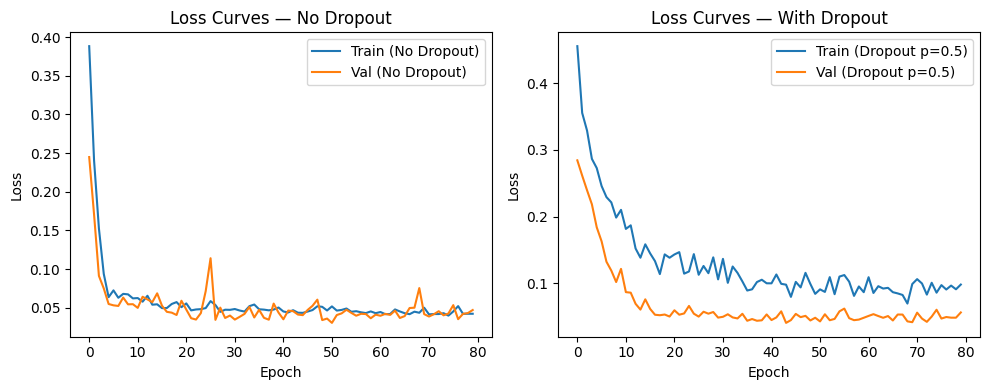

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(tr_no, label="Train (No Dropout)")
plt.plot(va_no, label="Val (No Dropout)")
plt.title("Loss Curves — No Dropout")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_do, label="Train (Dropout p=0.5)")
plt.plot(va_do, label="Val (Dropout p=0.5)")
plt.title("Loss Curves — With Dropout")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


**Q7 Discussion:** Aksar **dropout-based** model ke validation loss aur generalization behtar hotay hain kyun ke neurons randomly drop hoke co-adaptation kam hota hai. Is se model zyada robust features seekhta hai aur overfitting control hota hai.


# Question 8
---

## Step 0: BN/no-BN MLPs


In [14]:
class MLP_NoBN(nn.Module):
    def __init__(self, in_dim=2, h1=64, h2=32, out_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim, h1)
        self.f2 = nn.Linear(h1, h2)
        self.f3 = nn.Linear(h2, out_dim)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.act(self.f1(x))
        x = self.act(self.f2(x))
        x = self.f3(x)
        return x

class MLP_WithBN(nn.Module):
    # har hidden ke baad BatchNorm -> internal covariate shift ko control karne ki koshish
    def __init__(self, in_dim=2, h1=64, h2=32, out_dim=2):
        super().__init__()
        self.f1 = nn.Linear(in_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.f2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.f3 = nn.Linear(h2, out_dim)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.act(self.bn1(self.f1(x)))
        x = self.act(self.bn2(self.f2(x)))
        x = self.f3(x)
        return x

def train_until_acc(model, loader, max_epochs=200, lr=1e-2, target_acc=0.90, device="cpu"):
    # yeh function epoch-by-epoch train karta hai aur 90% training accuracy tak time note karta hai
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    reached_epoch = None
    acc_trace = []

    for ep in range(max_epochs):
        model.train()
        corr = 0
        total = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

            pred = logits.argmax(dim=1)
            corr += (pred == yb).sum().item()
            total += yb.size(0)
        train_acc = corr / total
        acc_trace.append(train_acc)

        if (reached_epoch is None) and (train_acc >= target_acc):
            reached_epoch = ep + 1  # 1-based for readability

    return model, acc_trace, reached_epoch


## Step 1: Train both


In [15]:
torch.manual_seed(123)
no_bn_model, no_bn_trace, no_bn_epoch90 = train_until_acc(MLP_NoBN(), train_loader, max_epochs=200, lr=1e-2, target_acc=0.90, device=device)

torch.manual_seed(123)
with_bn_model, with_bn_trace, with_bn_epoch90 = train_until_acc(MLP_WithBN(), train_loader, max_epochs=200, lr=1e-2, target_acc=0.90, device=device)

print(f"[NoBN] epoch to reach 90% train acc: {no_bn_epoch90}")
print(f"[WithBN] epoch to reach 90% train acc: {with_bn_epoch90}")

[NoBN] epoch to reach 90% train acc: 2
[WithBN] epoch to reach 90% train acc: 2


## Step 2: Plot train-acc traces


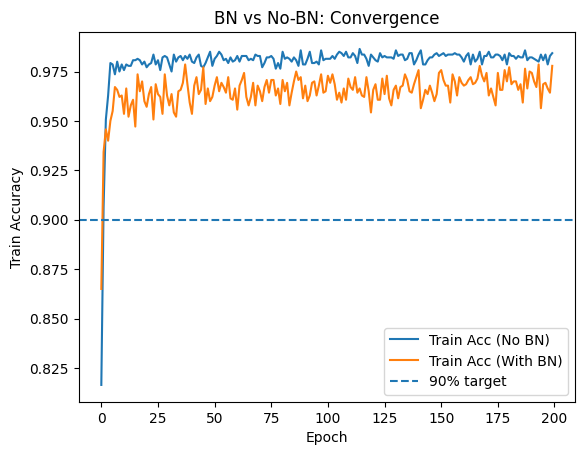

In [16]:
plt.figure()
plt.plot(no_bn_trace, label="Train Acc (No BN)")
plt.plot(with_bn_trace, label="Train Acc (With BN)")
plt.axhline(0.90, linestyle="--", label="90% target")
plt.xlabel("Epoch"); plt.ylabel("Train Accuracy"); plt.title("BN vs No-BN: Convergence")
plt.legend(); plt.show()


**Q8 Discussion:** BatchNorm per-layer activations ko normalize karke gradients ko **stable** banata hai, jis se learning rate zyada effective hota hai, exploding/vanishing ka risk kam hota hai, aur aam tor par **faster convergence** milti hai (kum epochs mein high accuracy).


# Question 9
---

In [17]:
from sklearn.model_selection import StratifiedKFold
import math

## Step 0: Helper — build MLP by width tuple


In [18]:
class MLP_Arch(nn.Module):
    def __init__(self, width_tuple=(16, 8, 1), in_dim=2, out_dim=2):
        super().__init__()
        h1, h2, _ = width_tuple
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, out_dim)
        )
    def forward(self, x):
        return self.net(x)

def train_for_epochs(model, Xtr, ytr, Xva, yva, epochs=60, lr=1e-2, device="cpu"):
        model = model.to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        crit = nn.CrossEntropyLoss()
        # numpy to tensors each epoch (small data so OK)
        Xtr_t = torch.from_numpy(Xtr).to(device)
        ytr_t = torch.from_numpy(ytr).to(device)
        Xva_t = torch.from_numpy(Xva).to(device)
        yva_t = torch.from_numpy(yva).to(device)

        for ep in range(epochs):
            model.train()
            opt.zero_grad()
            logits = model(Xtr_t)
            loss = crit(logits, ytr_t)
            loss.backward()
            opt.step()

        # validation acc
        model.eval()
        with torch.no_grad():
            pred = model(Xva_t).argmax(dim=1)
            acc = (pred == yva_t).float().mean().item()
        return acc

## Step 1: Define 5-fold CV and architectures


In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
architectures = [(16,8,1), (32,16,1), (64,32,1)]
mean_accs = {}

## Step 2: Run CV per architecture


In [20]:
for arch in architectures:
    fold_accs = []
    for tr_idx, va_idx in skf.split(X_aug, y_aug):
        Xtr, Xva = X_aug[tr_idx], X_aug[va_idx]
        ytr, yva = y_aug[tr_idx], y_aug[va_idx]

        torch.manual_seed(7)
        m = MLP_Arch(width_tuple=arch)
        acc = train_for_epochs(m, Xtr, ytr, Xva, yva, epochs=60, lr=1e-2, device=device)
        fold_accs.append(acc)
    mean_accs[arch] = float(np.mean(fold_accs))

## Step 3: Print results


In [21]:
print("5-Fold Mean Validation Accuracies:")
best_arch = None
best_score = -1.0
for arch, score in mean_accs.items():
    print(f"  Arch {arch} -> mean val acc = {score:.4f}")
    if score > best_score:
        best_score = score
        best_arch = arch

print(f"\nBest Architecture: {best_arch} with mean val acc = {best_score:.4f}")


5-Fold Mean Validation Accuracies:
  Arch (16, 8, 1) -> mean val acc = 0.8720
  Arch (32, 16, 1) -> mean val acc = 0.9625
  Arch (64, 32, 1) -> mean val acc = 0.9800

Best Architecture: (64, 32, 1) with mean val acc = 0.9800


**Q9 Note:** k-fold CV data ko mukhtalif splits par evaluate karke **variance** ko kam karta hai aur architecture selection ko zyada **reliable** banata hai.


# Question 10
---

## Step 0: Helper to compute average weight L2 norm


In [22]:
def avg_weight_l2(model):
    # saare Linear layers ke weights ka L2 norm average kar lete hain
    norms = []
    for p in model.parameters():
        if p.requires_grad and p.dim() >= 2:  # weight matrices
            norms.append(torch.norm(p.detach(), p=2).item())
    return float(np.mean(norms)) if norms else 0.0

## Step 1: Define a baseline MLP (same as NoDrop earlier for fairness)


In [23]:
def build_baseline():
    return MLP_NoDrop(in_dim=2, h1=64, h2=32, out_dim=2)

## Step 2: Train with and without L2 (weight_decay)


In [24]:
def train_eval(model, train_loader, val_loader, epochs=80, lr=1e-2, weight_decay=0.0, device="cpu"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.CrossEntropyLoss()

    def eval_loss(loader):
        model.eval()
        tot = 0.0; n = 0
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = crit(logits, yb)
                tot += loss.item() * xb.size(0)
                n += xb.size(0)
        return tot / n

    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

    tr_loss = eval_loss(train_loader)
    va_loss = eval_loss(val_loader)
    w_norm = avg_weight_l2(model)
    return tr_loss, va_loss, w_norm, model

## Step 3: Run both settings


In [25]:
torch.manual_seed(99)
tr_noL2, va_noL2, norm_noL2, m_noL2 = train_eval(build_baseline(), train_loader, val_loader, epochs=80, lr=1e-2, weight_decay=0.0, device=device)

torch.manual_seed(99)
tr_L2, va_L2, norm_L2, m_L2     = train_eval(build_baseline(), train_loader, val_loader, epochs=80, lr=1e-2, weight_decay=1e-3, device=device)

## Step 4: Report


In [26]:
print("=== Final Metrics (After Training) ===")
print(f"No L2   -> Train Loss: {tr_noL2:.4f} | Val Loss: {va_noL2:.4f} | Avg ||W||2: {norm_noL2:.4f}")
print(f"With L2 -> Train Loss: {tr_L2:.4f} | Val Loss: {va_L2:.4f} | Avg ||W||2: {norm_L2:.4f}")


=== Final Metrics (After Training) ===
No L2   -> Train Loss: 0.0633 | Val Loss: 0.0576 | Avg ||W||2: 8.8223
With L2 -> Train Loss: 0.0602 | Val Loss: 0.0515 | Avg ||W||2: 4.5467


**Q10 Discussion:** L2 regularization (weight decay) weights ko penalty deti hai jab unki magnitude barhti hai — is se weights **chhote** rehte hain, decision boundary smoother hoti hai aur **overfitting** control hota hai. Aksar validation loss improve hota hai, jab ke weight norms noticeably kam hotay hain.
